In [1]:
import sys
import logging
import pickle
import yaml
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from wmaze import MyEnv as Env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

In [2]:
nn_yaml = 'network_simplest.yaml'
internal_dim = 5
fname = 'wmaze_visualization'
set_network = None #['foraging_mb', 30, True]

In [3]:
parameters = {
    'nn_yaml': nn_yaml,
    'higher_dim_obs': True,
    'internal_dim': internal_dim,
    'fname': fname,
    'steps_per_epoch': 1000,
    'epochs': 40,
    'steps_per_test': 1000,
    'period_btw_summary_perfs': 1,
    'encoder_type': 'regular',
    'frame_skip': 2,
    'learning_rate': 1*1E-4,
    'learning_rate_decay': 1.0,
    'discount': 0.9,
    'epsilon_start': 1.0,
    'epsilon_min': 1.0,
    'epsilon_decay': 1000,
    'update_frequency': 1,
    'replay_memory_size': 100000, #50000
    'batch_size': 64,
    'freeze_interval': 1000,
    'deterministic': False,
    'loss_weights': [1E-1, 1E-2, 1E-2, 0, 0, 1E-2, 1., 0]
    }

In [9]:
rng = np.random.RandomState()
env = Env(rng)

# Algorithm
learning_algo = CRAR(
    env, parameters['freeze_interval'], parameters['batch_size'], rng,
    high_int_dim=False, internal_dim=parameters['internal_dim'],
    lr=parameters['learning_rate'], nn_yaml=parameters['nn_yaml'],
    double_Q=True, loss_weights=parameters['loss_weights'],
    encoder_type=parameters['encoder_type']
    )

# Policies
train_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 1.)
test_policy = EpsilonGreedyPolicy(learning_algo, env.nActions(), rng, 1.)

# Initialize Agent
agent = NeuralAgent(
    env, learning_algo, parameters['replay_memory_size'], 1,
    parameters['batch_size'], rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(10, 500)

# Attach controllers
agent.attach(bc.VerboseController( evaluate_on='epoch', periodicity=1))
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters['learning_rate'],
    learning_rate_decay=parameters['learning_rate_decay'],
    periodicity=1))
agent.attach(bc.TrainerController(
    evaluate_on='action', periodicity=parameters['update_frequency'],
    show_episode_avg_V_value=True, show_avg_Bellman_residual=True))
best_controller = bc.FindBestController(
    validationID=Env.VALIDATION_MODE,
    testID=None, unique_fname=fname, savefrequency=5)
agent.attach(best_controller)
agent.attach(bc.InterleavedTestEpochController(
    id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],
    periodicity=5, show_score=True, summarize_every=1, unique_fname=fname))

======= EPOCH 1: 0.005690813064575195 sec ======
======= EPOCH 2: 0.006711244583129883 sec ======
======= EPOCH 3: 0.00640106201171875 sec ======
======= EPOCH 4: 0.005950927734375 sec ======
======= EPOCH 5: 0.005591154098510742 sec ======
======= EPOCH 6: 0.00513911247253418 sec ======
======= EPOCH 7: 0.004868745803833008 sec ======
======= EPOCH 8: 0.004661083221435547 sec ======
======= EPOCH 9: 0.00434112548828125 sec ======
======= EPOCH 10: 0.00428009033203125 sec ======


In [10]:
agent._learning_algo.device

device(type='cpu')

In [ ]:
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters['epochs'], parameters['steps_per_epoch'])

Average (on the epoch) training loss: 0.034436497810296715
Episode average V value: 0
epoch 1:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZING TEST PERF
== Mean score per episode is 0.0 over 1 episodes ==


/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:161: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  torch.tensor(all_possib_inp).float().to(device)
/Users/chingfan

======= EPOCH 1: 11.007846117019653 sec ======
Average (on the epoch) training loss: 0.07900606394186616
Episode average V value: 0
epoch 2:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 2: 10.438261032104492 sec ======
Average (on the epoch) training loss: 0.09497505101934076
Episode average V value: 0
epoch 3:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 3: 10.431142091751099 sec ======
Average (on the epoch) training loss: 0.09972345060482621
Episode average V value: 0
epoch 4:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 4: 10.265645265579224 sec ======
Average (on the epoch) training loss: 0.12764019870013
Episode average V value: 0
epoch 5:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 5: 10.358500003814697 sec ======
Average (on the epoch) training loss: 0.17170616512745618
Episode average V value: 0
epoch 6:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZING TEST P

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 6: 10.929388761520386 sec ======
Average (on the epoch) training loss: 0.24361074829101562
Episode average V value: 0
epoch 7:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 7: 10.26268482208252 sec ======
Average (on the epoch) training loss: 0.287606555595994
Episode average V value: 0
epoch 8:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 8: 10.111759185791016 sec ======
Average (on the epoch) training loss: 0.31006812807917594
Episode average V value: 0
epoch 9:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 9: 10.095219135284424 sec ======
Average (on the epoch) training loss: 0.31134103612601755
Episode average V value: 0
epoch 10:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 10: 10.09253716468811 sec ======
Average (on the epoch) training loss: 0.31229007241129875
Episode average V value: 0
epoch 11:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZING TEST

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 11: 10.972178220748901 sec ======
Average (on the epoch) training loss: 0.31476850336790085
Episode average V value: 0
epoch 12:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 12: 10.194969892501831 sec ======
Average (on the epoch) training loss: 0.3044576118290424
Episode average V value: 0
epoch 13:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 13: 10.380242824554443 sec ======
Average (on the epoch) training loss: 0.30478465469181537
Episode average V value: 0
epoch 14:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 14: 10.71587586402893 sec ======
Average (on the epoch) training loss: 0.3120348098427057
Episode average V value: 0
epoch 15:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 15: 10.375076055526733 sec ======
Average (on the epoch) training loss: 0.30797689777612686
Episode average V value: 0
epoch 16:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZ

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 16: 10.838650941848755 sec ======
Average (on the epoch) training loss: 0.2987555842846632
Episode average V value: 0
epoch 17:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 17: 10.325737953186035 sec ======
Average (on the epoch) training loss: 0.29168323837220667
Episode average V value: 0
epoch 18:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 18: 10.164379119873047 sec ======
Average (on the epoch) training loss: 0.2900487292557955
Episode average V value: 0
epoch 19:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 19: 10.13198208808899 sec ======
Average (on the epoch) training loss: 0.28519998301565647
Episode average V value: 0
epoch 20:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 20: 10.104979038238525 sec ======
Average (on the epoch) training loss: 0.27674460861086847
Episode average V value: 0
epoch 21:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZ

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 21: 10.84262204170227 sec ======
Average (on the epoch) training loss: 0.2719179494082928
Episode average V value: 0
epoch 22:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 22: 10.210191011428833 sec ======
Average (on the epoch) training loss: 0.27249256332218647
Episode average V value: 0
epoch 23:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 23: 10.099289894104004 sec ======
Average (on the epoch) training loss: 0.271624302983284
Episode average V value: 0
epoch 24:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 24: 10.110937118530273 sec ======
Average (on the epoch) training loss: 0.26863835233449934
Episode average V value: 0
epoch 25:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 25: 10.120764970779419 sec ======
Average (on the epoch) training loss: 0.2674413592219353
Episode average V value: 0
epoch 26:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZIN

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 26: 10.911594867706299 sec ======
Average (on the epoch) training loss: 0.26567451491951943
Episode average V value: 0
epoch 27:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 27: 10.211090326309204 sec ======
Average (on the epoch) training loss: 0.26306987327337267
Episode average V value: 0
epoch 28:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 28: 10.137255191802979 sec ======
Average (on the epoch) training loss: 0.26092678609490394
Episode average V value: 0
epoch 29:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 29: 10.237837076187134 sec ======
Average (on the epoch) training loss: 0.2583083011507988
Episode average V value: 0
epoch 30:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 30: 10.113349914550781 sec ======
Average (on the epoch) training loss: 0.2622898863852024
Episode average V value: 0
epoch 31:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARI

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 31: 10.85989785194397 sec ======
Average (on the epoch) training loss: 0.2600491568297148
Episode average V value: 0
epoch 32:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 32: 10.227678060531616 sec ======
Average (on the epoch) training loss: 0.25874692940711974
Episode average V value: 0
epoch 33:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 33: 10.150495052337646 sec ======
Average (on the epoch) training loss: 0.25689632292091846
Episode average V value: 0
epoch 34:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 34: 10.462723731994629 sec ======
Average (on the epoch) training loss: 0.25624693343043325
Episode average V value: 0
epoch 35:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 35: 10.298968076705933 sec ======
Average (on the epoch) training loss: 0.2572170992642641
Episode average V value: 0
epoch 36:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
SUMMARIZ

/Users/chingfang/Code/deer/examples/test_CRAR/wmaze.py:232: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  line3 = ax.scatter(x[label_idxs], y[label_idxs], z[label_idxs],


======= EPOCH 36: 10.920667171478271 sec ======
Average (on the epoch) training loss: 0.25271326887607576
Episode average V value: 0
epoch 37:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 37: 10.227853059768677 sec ======
Average (on the epoch) training loss: 0.2542636751532555
Episode average V value: 0
epoch 38:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 38: 10.314677953720093 sec ======
Average (on the epoch) training loss: 0.254055367693305
Episode average V value: 0
epoch 39:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 39: 10.128032207489014 sec ======
Average (on the epoch) training loss: 0.2513179080188274
Episode average V value: 0
epoch 40:
Learning rate: 0.0001
Discount factor: 0.9
Epsilon: 1.0
======= EPOCH 40: 10.110722780227661 sec ======
Best neural net obtained after 1 epochs, with validation score 0.0


## Visualize performance

In [34]:
agent.setNetwork(f'{fname}/fname', nEpoch=5)

In [80]:
agent.setNetwork(f'foraging_simpler_dim10/foraging_entro_5/fname', nEpoch=40)

In [5]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

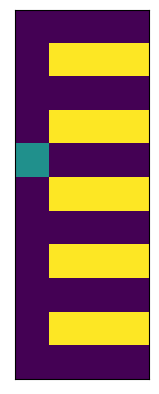

3


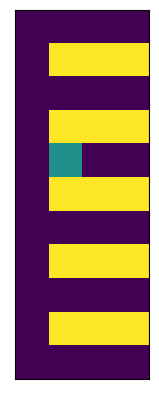

3


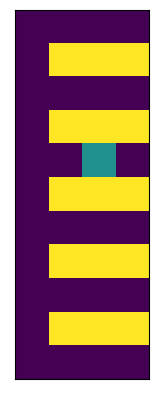

1


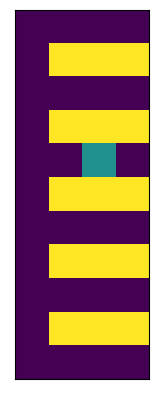

2


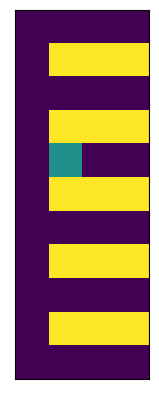

0


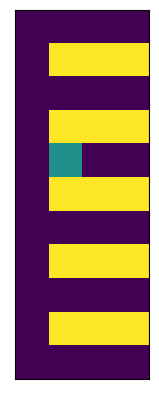

In [6]:
%matplotlib inline

frames = []

for i in range(100):
    obs = env.observe()
    _obs = obs[0].reshape((env._maze_width, env._maze_length))
    #_obs = obs[0].reshape((env._maze_length, env._maze_width))
    plt.figure()
    frame = _obs.squeeze()
    plt.imshow(frame)
    frames.append(frame)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if is_terminal: break
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = (env.inTerminalState() or action ==0)

### As animation

<IPython.core.display.Javascript object>


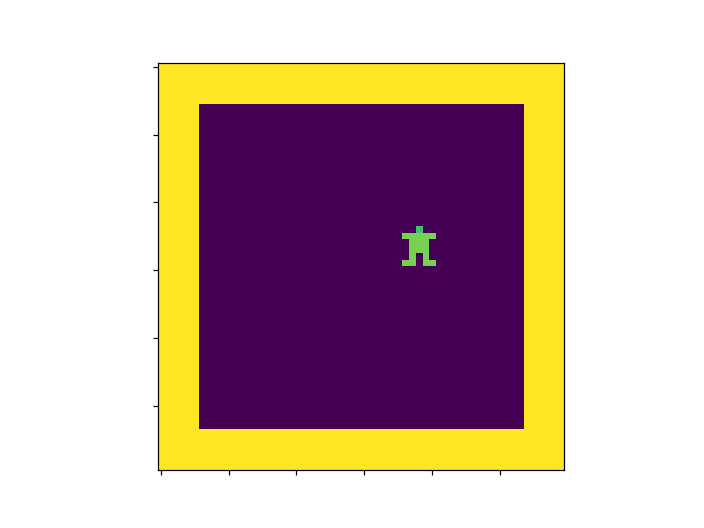

MovieWriter ffmpeg unavailable; using Pillow instead.
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 242, in get_text_width_height_descent
    w /= 64.0  # convert from subpixels
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 242, in get_text_width_height_descent
    w /= 64.0  # convert from subpixels
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/

Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):


    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
Traceback (most recent call last):
  File "/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 210, in draw_text
    d = font.get_descent() / 64.0
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/share/ctn/users/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/matplotli

In [91]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros((height, width)))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    im = ax.imshow(frames[i])
#     obs = env.observe()
#     _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
#     _obs = np.flip(_obs.squeeze())
#     im = ax.imshow(_obs)
#     for i in range(len(obs)):
#         agent._state[i][0:-1] = agent._state[i][1:]
#         agent._state[i][-1] = obs[i]
#         V, action, reward, _ = agent._step()
#         agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=len(frames), blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior_r2_3.gif', writer="ffmpeg", fps = 4)
fig.show()